## About

This plot is a waffle chart showing the evolution of the number of animals adopted at the Long Beach animal shelter.

The chart was made by [Joseph Barbier](https://www.barbierjoseph.com/). Thanks to him for accepting sharing his work here!

Let's see what the final picture will look like:

![small multiple waffle chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-waffle-chart-with-groups-evolution.png?raw=true)


## Libraries

First, we need to install the following libraries:

- `pandas`
- `matplotlib`
- `pywaffle`
- `pypalettes`
- `pyfonts`
- `drawarrow`
- `highlight_text`


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaffle import Waffle
from pypalettes import load_cmap
from pyfonts import load_font
from drawarrow import ax_arrow, fig_arrow
from highlight_text import fig_text

## Dataset

First of all, we need to fetch the dataset from the tidytuesday repository, and clean it a bit:


In [2]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-03-04/longbeach.csv"
df = pd.read_csv(url)
df["outcome_year"] = pd.to_datetime(df["outcome_date"]).dt.year
df = df[df["outcome_type"] == "adoption"]
df = df[["outcome_year", "animal_type"]]
df_agg = df.groupby(["outcome_year", "animal_type"], as_index=False).size()
df_agg = df_agg[~df_agg["animal_type"].isin(["amphibian", "livestock"])]
all_years = df_agg["outcome_year"].unique()
all_animals = df_agg["animal_type"].unique()
idx = pd.MultiIndex.from_product(
    [all_years, all_animals], names=["outcome_year", "animal_type"]
)
df_agg = (
    df_agg.set_index(["outcome_year", "animal_type"])
    .reindex(idx, fill_value=0)
    .reset_index()
)
df_agg = df_agg.sort_values(["outcome_year", "animal_type"])
df_agg[df_agg["outcome_year"] == 2024].sort_values("size")
df_agg["iscatordog"] = df_agg["animal_type"].isin(["cat", "dog"])
df_agg.head()

,outcome_year,animal_type,size,iscatordog
0,2017.0,bird,1,False
1,2017.0,cat,222,True
2,2017.0,dog,205,True
3,2017.0,guinea pig,3,False
4,2017.0,other,1,False


## Minimalist version

The core of the chart is to create a Figure with 8 Axes (one for each year).

Then, we iterate each of those Axes and add the waffle chart for this year.

The main trick here is to get the total value with the year with highest sum (`max_year_value`), and use it to fill all other years with white squares to ensure waffle charts have different sizes. Otherwise they'll have the same size and don't really make sense.


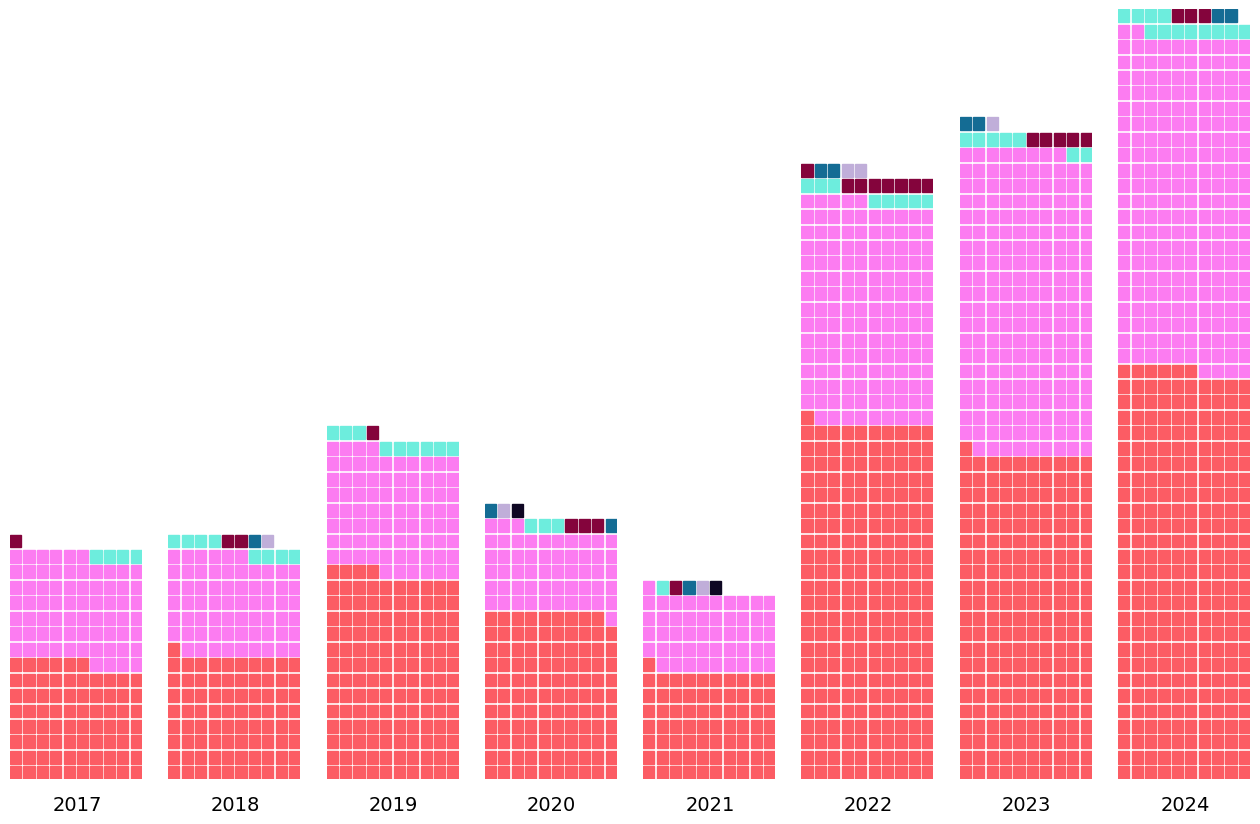

In [3]:
n_colors = df_agg["animal_type"].nunique()
colors = load_cmap("CrystalGems", keep_first_n=n_colors, shuffle=3).colors + ["white"]

max_year_value = df_agg[df_agg["outcome_year"] == 2024]["size"].sum()

ncols = df_agg["outcome_year"].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(16, 10))

for year, ax in zip(df_agg["outcome_year"].unique(), axs):
    values = list(df_agg[df_agg["outcome_year"] == year]["size"].values)
    values = sorted(values, reverse=True)
    values.append(max_year_value - sum(values))

    Waffle.make_waffle(
        ax=ax,
        rows=50,
        columns=10,
        values=values,
        vertical=True,
        colors=colors,
    )

    ax.text(x=0.1, y=-0.04, s=f"{int(year)}", fontsize=14, ha="center")

plt.show()


## Labels

All labels are added using the `text()` function, with trials and errors to find the perfect location. We also use the associate colors to serve as a legend.

The process is pretty much the same for arrows, but using `ax_arrow()`/`fig_arrow()`.


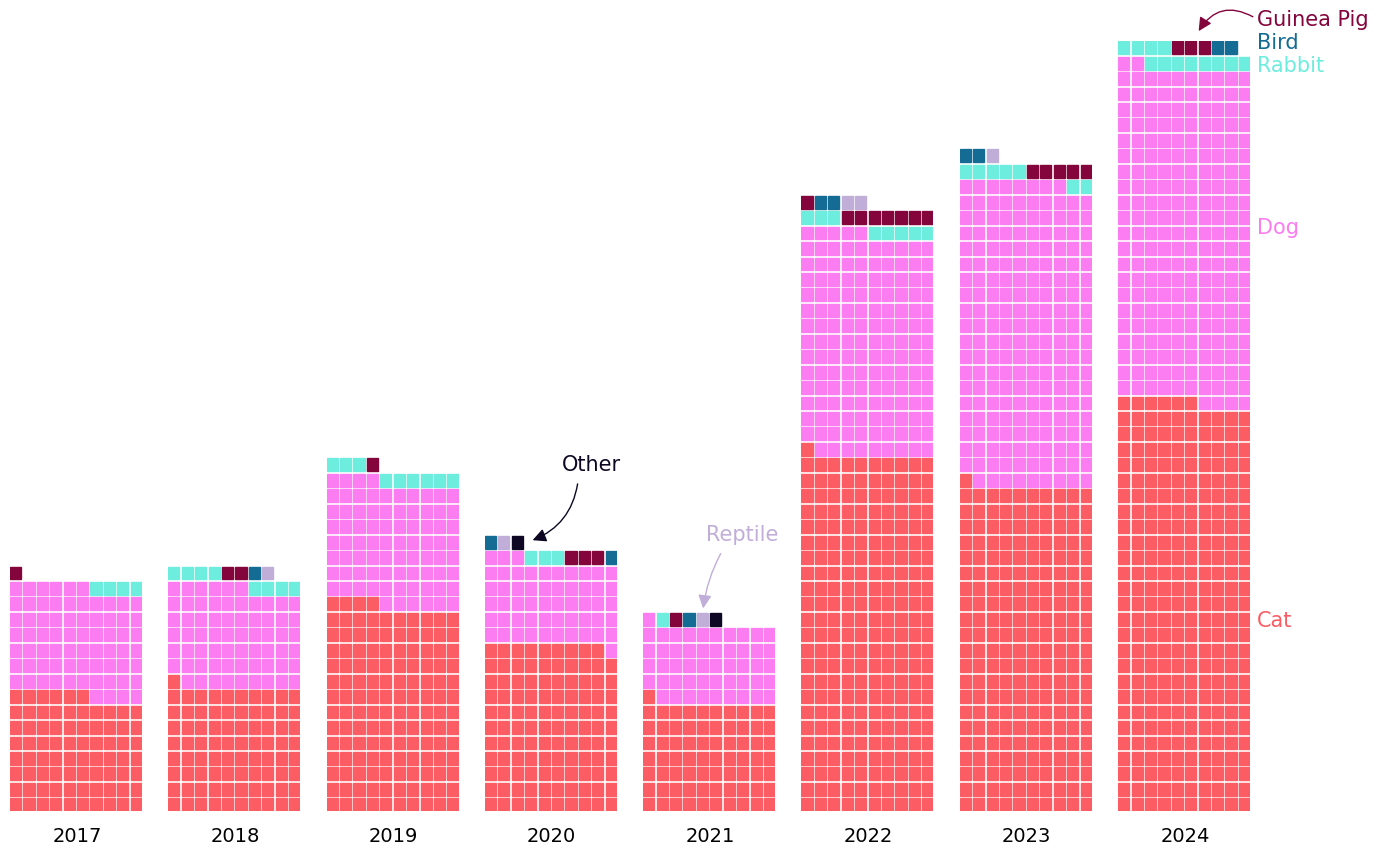

In [4]:
n_colors = df_agg["animal_type"].nunique()
colors = load_cmap("CrystalGems", keep_first_n=n_colors, shuffle=3).colors + ["white"]

max_year_value = df_agg[df_agg["outcome_year"] == 2024]["size"].sum()

ncols = df_agg["outcome_year"].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(16, 10))

for year, ax in zip(df_agg["outcome_year"].unique(), axs):
    values = list(df_agg[df_agg["outcome_year"] == year]["size"].values)
    values = sorted(values, reverse=True)
    values.append(max_year_value - sum(values))

    Waffle.make_waffle(
        ax=ax,
        rows=50,
        columns=10,
        values=values,
        vertical=True,
        colors=colors,
    )

    ax.text(x=0.1, y=-0.04, s=f"{int(year)}", fontsize=14, ha="center")

label_params = dict(
    x=1.05,
    size=15,
    transform=axs[ncols - 1].transAxes,
    clip_on=False,
)
axs[ncols - 1].text(y=0.24, s="Cat", color=colors[0], **label_params)
axs[ncols - 1].text(y=0.75, s="Dog", color=colors[1], **label_params)
axs[ncols - 1].text(y=0.96, s="Rabbit", color=colors[2], **label_params)
axs[ncols - 1].text(y=1.02, s="Guinea Pig", color=colors[3], **label_params)
axs[ncols - 1].text(y=0.99, s="Bird", color=colors[4], **label_params)
fig.text(
    x=0.56,
    y=0.38,
    s="Reptile",
    size=15,
    color=colors[5],
)
fig.text(
    x=0.47,
    y=0.45,
    s="Other",
    size=15,
    color=colors[6],
)

arrow_params = dict(
    ax=axs[ncols - 1],
    transform=axs[ncols - 1].transAxes,
    clip_on=False,
)
ax_arrow([1.04, 1.03], [0.6, 1.01], color=colors[3], radius=0.5, **arrow_params)
fig_arrow(
    [0.57, 0.37], [0.558, 0.31], color=colors[5], radius=0.1, clip_on=False, fig=fig
)
fig_arrow(
    [0.48, 0.44], [0.45, 0.38], color=colors[6], radius=-0.3, clip_on=False, fig=fig
)

plt.show()


## y-scale

Due to the way `PyWaffle` works, we have to create the yscale line ourselves.

We use the `text()` function for labels, and `axhline()` `avhline()` for the lines.


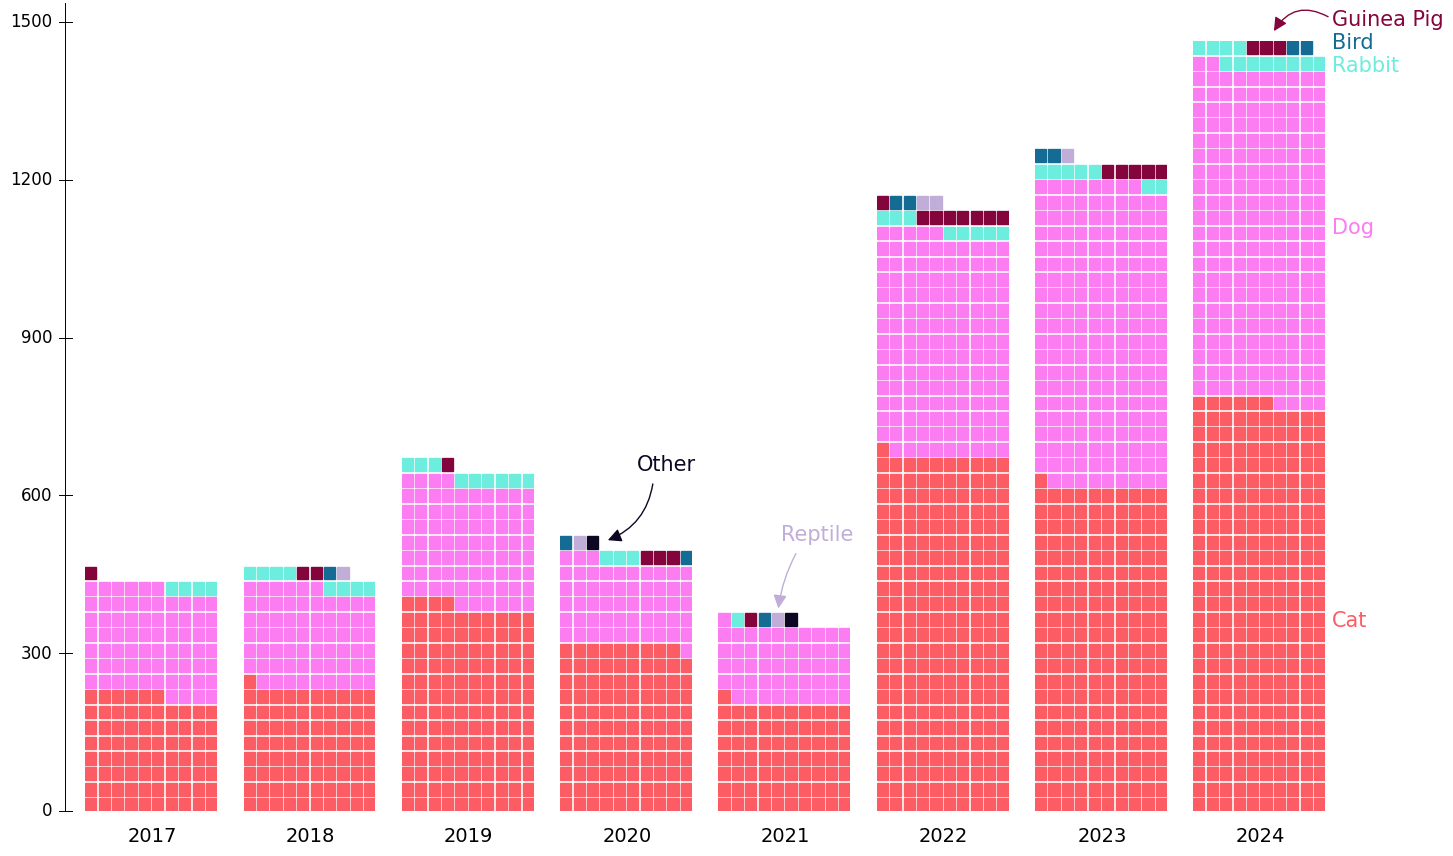

In [ ]:
n_colors = df_agg["animal_type"].nunique()
colors = load_cmap("CrystalGems", keep_first_n=n_colors, shuffle=3).colors + ["white"]

max_year_value = df_agg[df_agg["outcome_year"] == 2024]["size"].sum()

ncols = df_agg["outcome_year"].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(16, 10))

# Add y scale
y_ticks = [0, 300, 600, 900, 1200, 1500]
for y_tick in y_ticks:
    axs[0].text(
        x=-0.25,
        y=y_tick / max_year_value,
        s=f"{y_tick}",
        size=12,
        va="center",
        ha="right",
        transform=axs[0].transAxes,
    )
    axs[0].axhline(
        y=y_tick / max_year_value,
        xmin=-0.2,
        xmax=-0.1,
        clip_on=False,
        color="black",
        linewidth=0.7,
    )
axs[0].axvline(x=-0.03, ymax=1.05, clip_on=False, color="black", linewidth=0.7)

for year, ax in zip(df_agg["outcome_year"].unique(), axs):
    values = list(df_agg[df_agg["outcome_year"] == year]["size"].values)
    values = sorted(values, reverse=True)
    values.append(max_year_value - sum(values))

    Waffle.make_waffle(
        ax=ax,
        rows=50,
        columns=10,
        values=values,
        vertical=True,
        colors=colors,
    )

    ax.text(x=0.1, y=-0.04, s=f"{int(year)}", fontsize=14, ha="center")

label_params = dict(
    x=1.05,
    size=15,
    transform=axs[ncols - 1].transAxes,
    clip_on=False,
)
axs[ncols - 1].text(y=0.24, s="Cat", color=colors[0], **label_params)
axs[ncols - 1].text(y=0.75, s="Dog", color=colors[1], **label_params)
axs[ncols - 1].text(y=0.96, s="Rabbit", color=colors[2], **label_params)
axs[ncols - 1].text(y=1.02, s="Guinea Pig", color=colors[3], **label_params)
axs[ncols - 1].text(y=0.99, s="Bird", color=colors[4], **label_params)
fig.text(
    x=0.56,
    y=0.38,
    s="Reptile",
    size=15,
    color=colors[5],
)
fig.text(
    x=0.47,
    y=0.45,
    s="Other",
    size=15,
    color=colors[6],
)

arrow_params = dict(
    ax=axs[ncols - 1],
    transform=axs[ncols - 1].transAxes,
    clip_on=False,
)
ax_arrow([1.04, 1.03], [0.6, 1.01], color=colors[3], radius=0.5, **arrow_params)
fig_arrow(
    [0.57, 0.37], [0.558, 0.31], color=colors[5], radius=0.1, clip_on=False, fig=fig
)
fig_arrow(
    [0.48, 0.44], [0.45, 0.38], color=colors[6], radius=-0.3, clip_on=False, fig=fig
)

plt.show()


## Title and fonts

We use 3 variations of the Roboto font here, depending on the labels. We load them using `load_font()`.

The title/subtitle and the captions are added via `text()`.


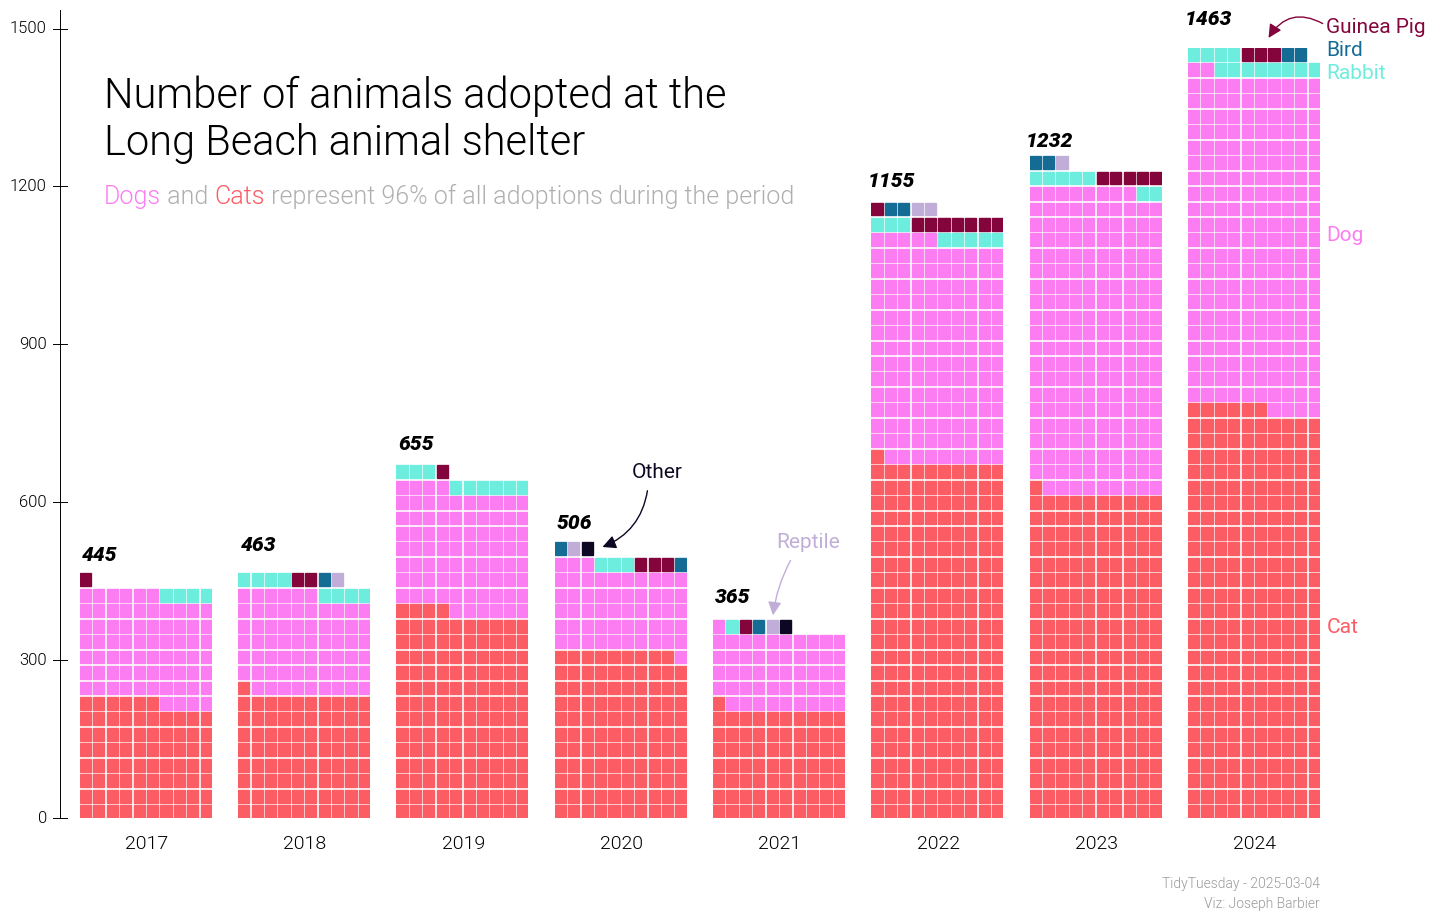

In [8]:
repo_url = "https://github.com/googlefonts/roboto-2/blob/main/src/hinted"
lightfont = load_font(f"{repo_url}/Roboto-Light.ttf?raw=true")
regularfont = load_font(f"{repo_url}/Roboto-Regular.ttf?raw=true")
italicfont = load_font(f"{repo_url}/Roboto-BlackItalic.ttf?raw=true")

n_colors = df_agg["animal_type"].nunique()
colors = load_cmap("CrystalGems", keep_first_n=n_colors, shuffle=3).colors + ["white"]

max_year_value = df_agg[df_agg["outcome_year"] == 2024]["size"].sum()

ncols = df_agg["outcome_year"].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(16, 10))

y_ticks = [0, 300, 600, 900, 1200, 1500]
for y_tick in y_ticks:
    axs[0].text(
        x=-0.25,
        y=y_tick / max_year_value,
        s=f"{y_tick}",
        size=12,
        va="center",
        ha="right",
        transform=axs[0].transAxes,
        font=lightfont,
    )
    axs[0].axhline(
        y=y_tick / max_year_value,
        xmin=-0.2,
        xmax=-0.1,
        clip_on=False,
        color="black",
        linewidth=0.7,
    )
axs[0].axvline(x=-0.03, ymax=1.05, clip_on=False, color="black", linewidth=0.7)


for year, ax in zip(df_agg["outcome_year"].unique(), axs):
    values = list(df_agg[df_agg["outcome_year"] == year]["size"].values)
    values = sorted(values, reverse=True)
    values.append(max_year_value - sum(values))

    Waffle.make_waffle(
        ax=ax,
        rows=50,
        columns=10,
        values=values,
        vertical=True,
        colors=colors,
    )

    ax.text(x=0.1, y=-0.04, s=f"{int(year)}", fontsize=14, ha="center", font=lightfont)
    adj_y = 0.03
    ax.text(
        x=0.03,
        y=sum(values[:-1]) / max_year_value + adj_y,
        s=f"{sum(values[:-1])}",
        fontsize=15,
        ha="center",
        font=italicfont,
    )

label_params = dict(
    x=1.05,
    size=15,
    transform=axs[ncols - 1].transAxes,
    font=regularfont,
    clip_on=False,
)
axs[ncols - 1].text(y=0.24, s="Cat", color=colors[0], **label_params)
axs[ncols - 1].text(y=0.75, s="Dog", color=colors[1], **label_params)
axs[ncols - 1].text(y=0.96, s="Rabbit", color=colors[2], **label_params)
axs[ncols - 1].text(y=1.02, s="Guinea Pig", color=colors[3], **label_params)
axs[ncols - 1].text(y=0.99, s="Bird", color=colors[4], **label_params)
fig.text(
    x=0.56,
    y=0.38,
    s="Reptile",
    size=15,
    font=regularfont,
    color=colors[5],
)
fig.text(
    x=0.47,
    y=0.45,
    s="Other",
    size=15,
    font=regularfont,
    color=colors[6],
)

arrow_params = dict(
    ax=axs[ncols - 1],
    transform=axs[ncols - 1].transAxes,
    clip_on=False,
)
ax_arrow([1.04, 1.03], [0.6, 1.01], color=colors[3], radius=0.5, **arrow_params)
fig_arrow(
    [0.57, 0.37], [0.558, 0.31], color=colors[5], radius=0.1, clip_on=False, fig=fig
)
fig_arrow(
    [0.48, 0.44], [0.45, 0.38], color=colors[6], radius=-0.3, clip_on=False, fig=fig
)

title = """
Number of animals adopted at the\nLong Beach animal shelter
"""
fig.text(x=0.14, y=0.9, s=title, size=30, font=lightfont, va="top")

share_catdog = df_agg[df_agg["iscatordog"]]["size"].sum() / df_agg["size"].sum() * 100
subtitle = f"""
<Dogs> and <Cats> represent {share_catdog:.0f}% of all adoptions during the period
"""
fig_text(
    x=0.14,
    y=0.75,
    s=subtitle,
    size=18,
    font=lightfont,
    color="#afafaf",
    va="top",
    highlight_textprops=[{"color": colors[1]}, {"color": colors[0]}],
)

source_params = dict(ha="right", font=lightfont, color="#9a9a9a", size=10)
fig.text(x=0.9, y=0.04, s="TidyTuesday - 2025-03-04", **source_params)
fig.text(x=0.9, y=0.02, s="Viz: Joseph Barbier", **source_params)

fig.savefig(
    "../../static/graph/web-waffle-chart-with-groups-evolution.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Going further

- [Another waffle chart for a time series](/web-waffle-chart-for-time-series)
- [A waffle chart to represent shares](/web-waffle-chart-as-share)
- [Learn more about pywaffle](/waffle-chart)
